By [Kevin Michalewicz](https://kevinmichalewicz.com) on May 2023

This notebook discusses feature interpretation in the context of ANTIPASTI.

In [1]:
# General imports
import cv2
import glob
import itertools
import os
import pandas as pd
import matplotlib
import numpy as np
import subprocess
import torch

from copy import deepcopy
from matplotlib.colors import CenteredNorm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# for reading and displaying images
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from scipy.stats import chi2
%matplotlib inline

# PyTorch-related libraries
from adabelief_pytorch import AdaBelief

# ANTIPASTI
from antipasti.model.model import ANTIPASTI
from antipasti.preprocessing.preprocessing import Preprocessing
from antipasti.utils.explaining_utils import compute_umap, compute_region_importance, compute_residue_importance, get_test_contribution, get_maps_of_interest, get_output_representations, plot_map_with_regions
from antipasti.utils.torch_utils import load_checkpoint

# Loading results

In [2]:
# Parameters
modes = 100
n_filters = 4
filter_size = 4
pooling_size = 1
n_max_epochs = 422

mode = 'fully-extended' # Choose between 'fully-extended' and 'fully-cropped'
pathological = ['5omm', '5i5k', '1uwx', '1mj7', '1qfw', '1qyg', '4ffz', '3ifl', '3lrh', '3pp4', '3ru8', '3t0w', '3t0x', '4fqr', '4gxu', '4jfx', '4k3h', '4jfz', '4jg0', '4jg1', '4jn2', '4o4y', '4qxt', '4r3s', '4w6y', '4w6y', '5ies', '5ivn', '5j57', '5kvd', '5kzp', '5mes', '5nmv', '5sy8', '5t29', '5t5b', '5vag', '3etb', '3gkz', '3uze', '3uzq', '4f9l', '4gqp', '4r2g', '5c6t', '3fku', '1oau', '1oay']
scfv = ['4gqp', '3etb', '3gkz', '3uze', '3uzq', '3gm0', '4f9l', '6ejg', '6ejm', '1h8s', '5dfw', '6cbp', '4f9p', '5kov', '1dzb', '5j74', '5aaw', '3uzv', '5aam', '3ux9', '5a2j', '5a2k', '5a2i', '3fku', '5yy4', '3uyp', '5jyl', '1y0l', '1p4b', '3kdm', '4lar', '4ffy', '2ybr', '1mfa', '5xj3', '5xj4', '4kv5', '5vyf'] 
nanobodies = ['1g6v', '1kxq', '1kxt', '1kxv', '1op9', '1ri8', '1zmy', '1zv5', '1zvy', '2p42', '2p43', '2p44', '2p45', '2p46', '2p47', '2p48', '2p49', '2p4a', '2vyr', '2x89', '3eba', '3ogo', '3p0g', '3p9w', '3qsk', '3qxt', '3qxv', '3zkq', '4eig', '4eiz', '4hjj', '4kfz', '4krl', '4pgj', '4pou', '4w6w', '4w6y', '4wem', '4wen', '4weu', '4x7d', '4x7e', '4x7f', '4y8d', '4z9k', '5boz', '5dmj', '5e7f', '5fhx', '5fv2', '5hgg', '5hvf', '5hvg', '5imk', '5imm', '5ip4', '5ivn', '5j56', '5j57', '5jds', '5lhn', '5m2i', '5m2j', '5m2m', '5my6', '5mzv', '5n88', '5nqw', '5o03', '5o05', '5o0w', '5o2u', '5omm', '5omn', '5sv3', '5toj', '5u4m', '5vm0', '5y7z', '5y80', '6ehg', '6fe4', '6h7n', '6h7o']
pathological += scfv
stage = 'predicting'
dccm_map_path = 'dccm_maps_full_ags_100/'

test_data_path = '../notebooks/test_data/'
test_dccm_map_path = 'dccm_map/'
test_residues_path = 'list_of_residues/'
test_structure_path = 'structure/'
test_pdb = '4yhi'

# Pre-processing
preprocessed_data = Preprocessing(dccm_map_path=dccm_map_path, modes=modes, pathological=pathological, mode=mode, stage=stage, test_data_path=test_data_path, test_dccm_map_path=test_dccm_map_path, test_residues_path=test_residues_path, test_structure_path=test_structure_path, test_pdb_id=test_pdb, residues_path='lists_of_residues_explainability/')
input_shape = preprocessed_data.test_x.shape[-1]

# Loading the actual checkpoint and learnt filters
path = '../checkpoints/full_ags_n_modes/100_modes/model_epochs_' + str(n_max_epochs) + '_modes_' + str(modes) + '_pool_' + str(pooling_size) + '_filters_' + str(n_filters) + '_size_' + str(filter_size) + '.pt'
model = load_checkpoint(path, input_shape)[0]
learnt_filter = np.load('../checkpoints/full_ags_n_modes/100_modes/learnt_filter_epochs_'+str(n_max_epochs)+'_modes_'+str(modes)+'_pool_'+str(pooling_size)+'_filters_'+str(n_filters)+'_size_'+str(filter_size)+'.npy')
model.eval()

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


ANTIPASTI(
  (conv1): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=334084, out_features=1, bias=False)
)

# Obtaining maps of interest

In [3]:
mean_learnt, mean_image, mean_diff_image = get_maps_of_interest(preprocessed_data, learnt_filter)

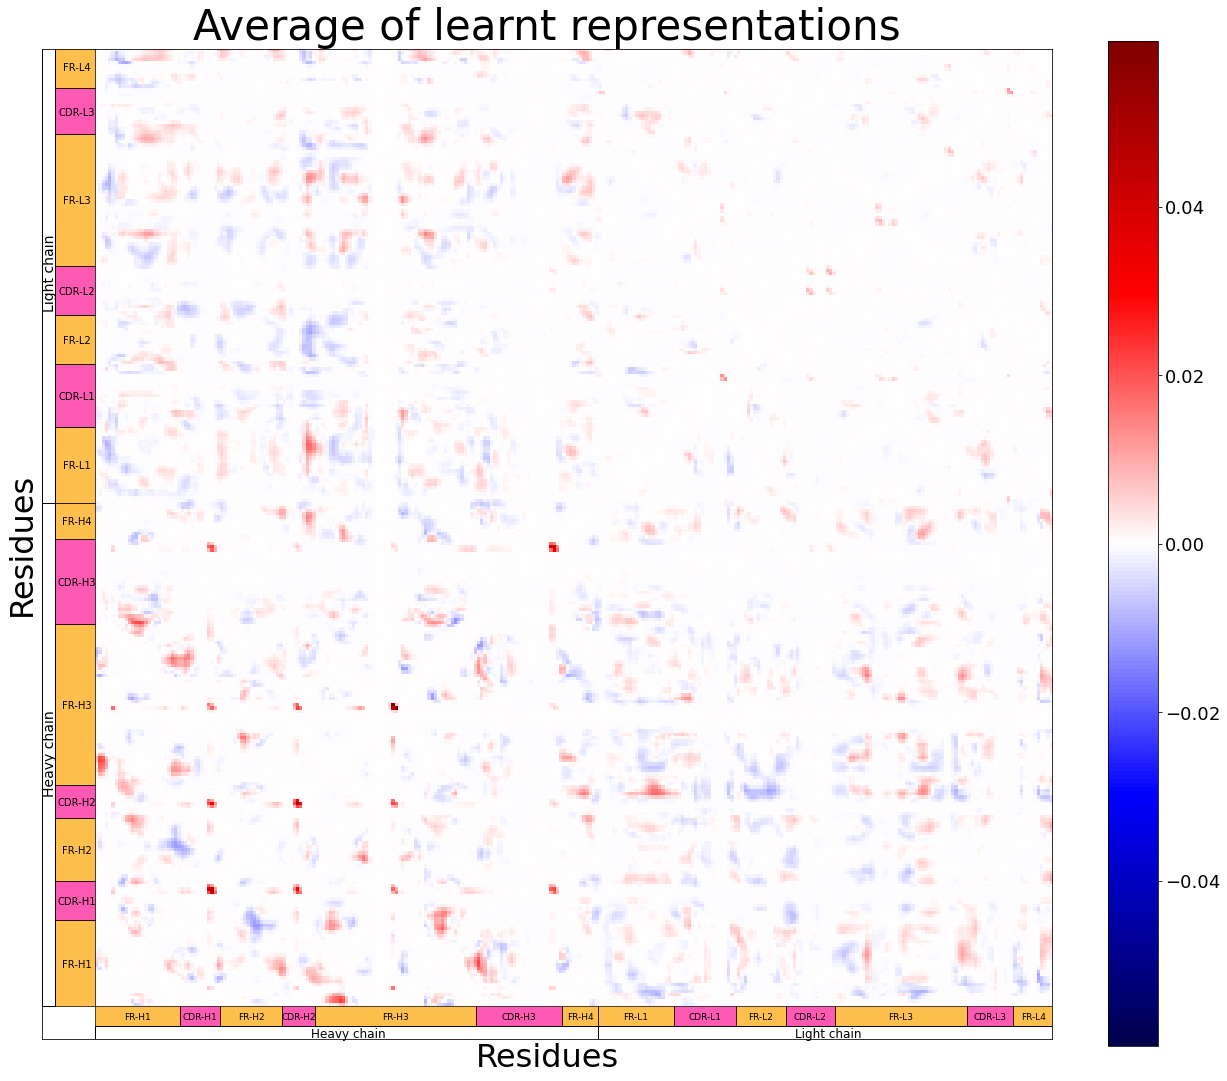

In [4]:
plot_map_with_regions(preprocessed_data, mean_learnt, 'Average of learnt representations')

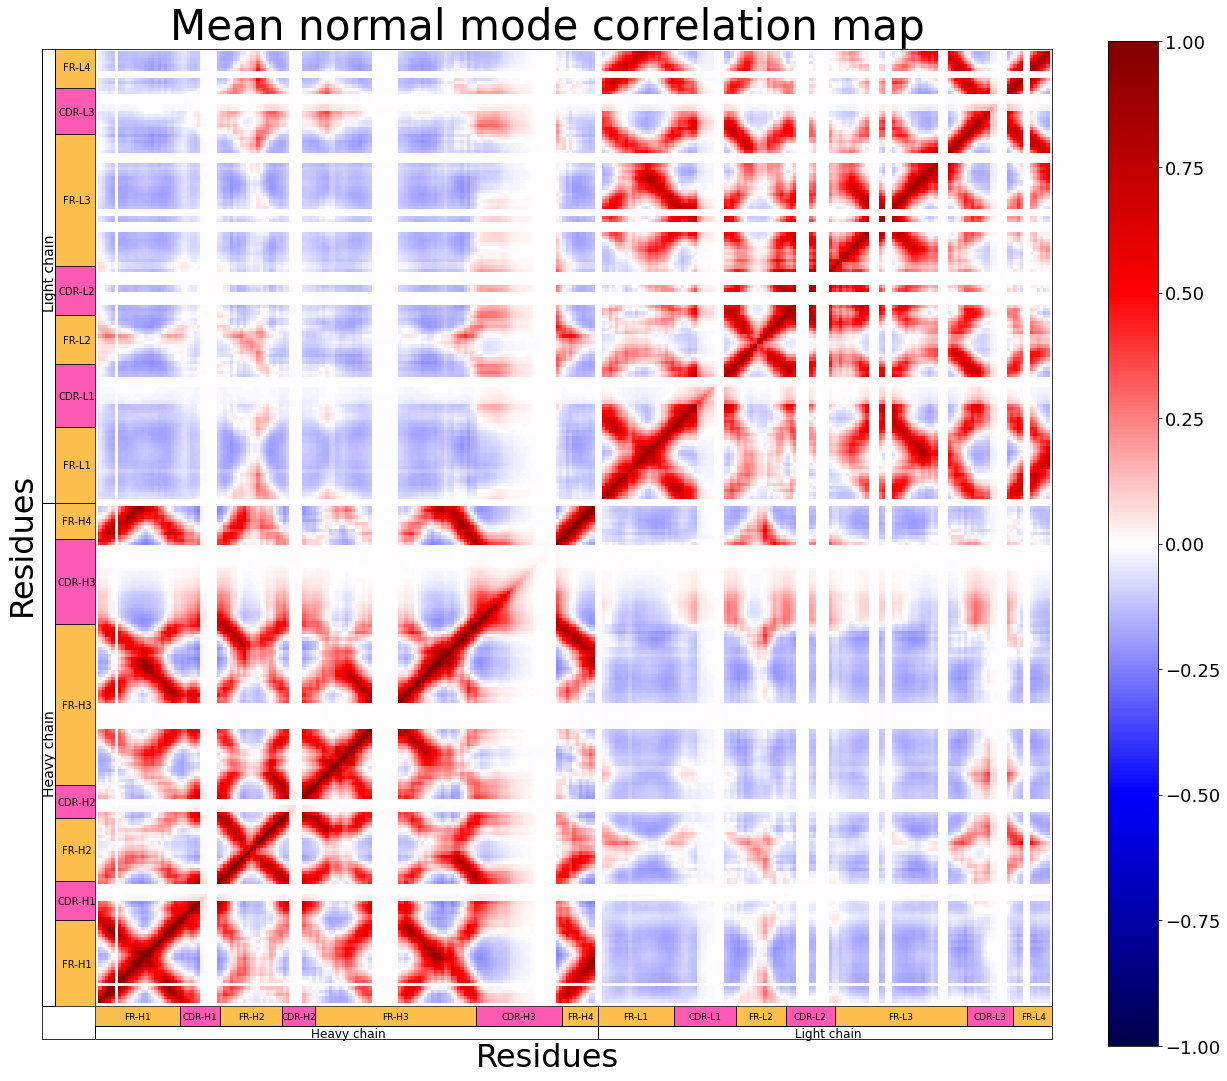

In [5]:
plot_map_with_regions(preprocessed_data, mean_image, 'Mean normal mode correlation map')

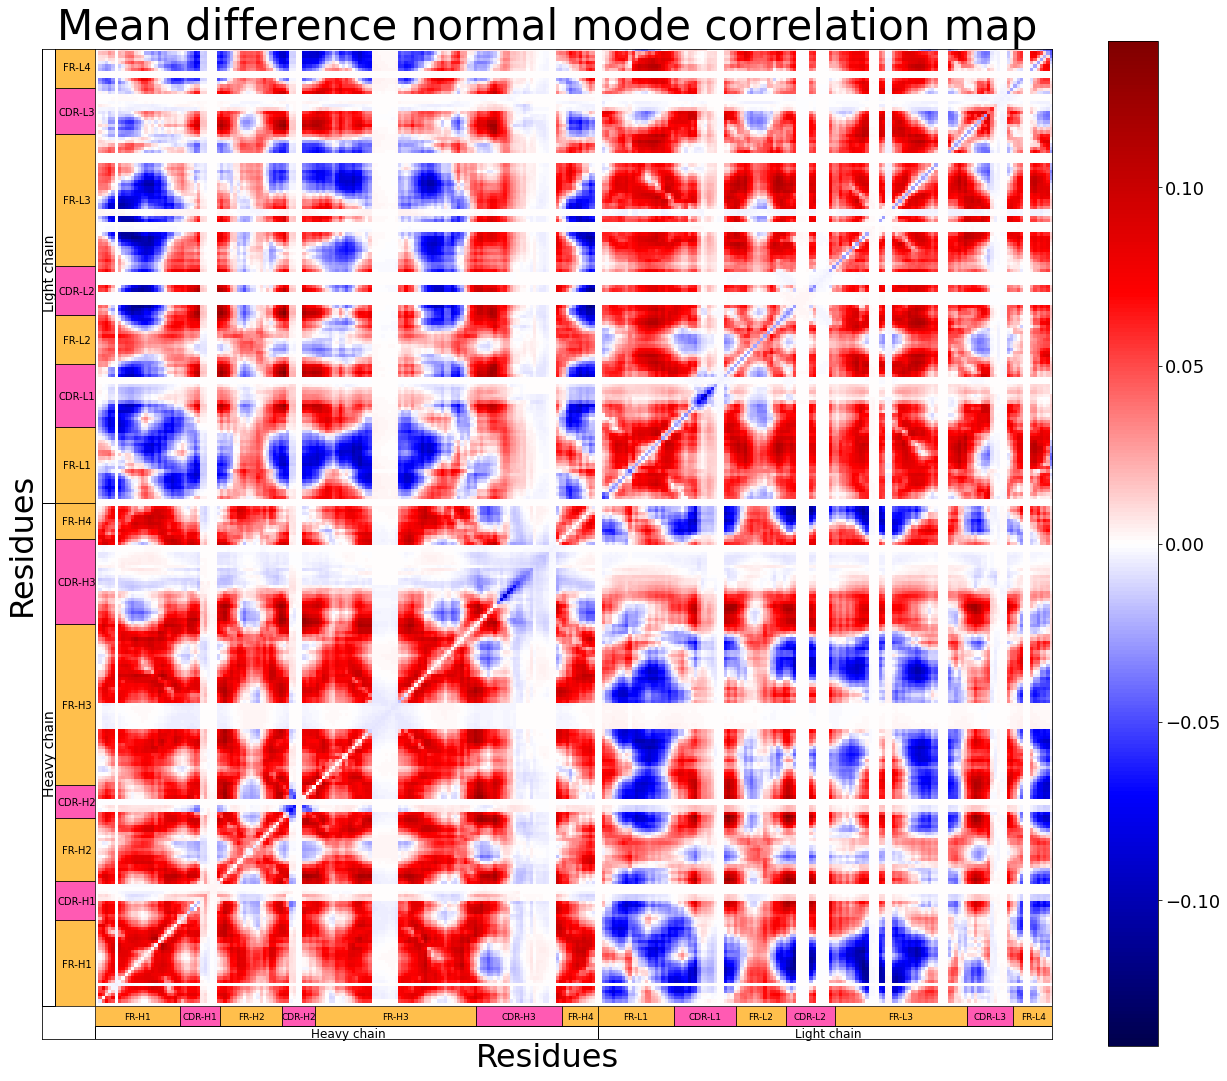

In [6]:
plot_map_with_regions(preprocessed_data, mean_diff_image, 'Mean difference normal mode correlation map')

# Contribution of a test sample

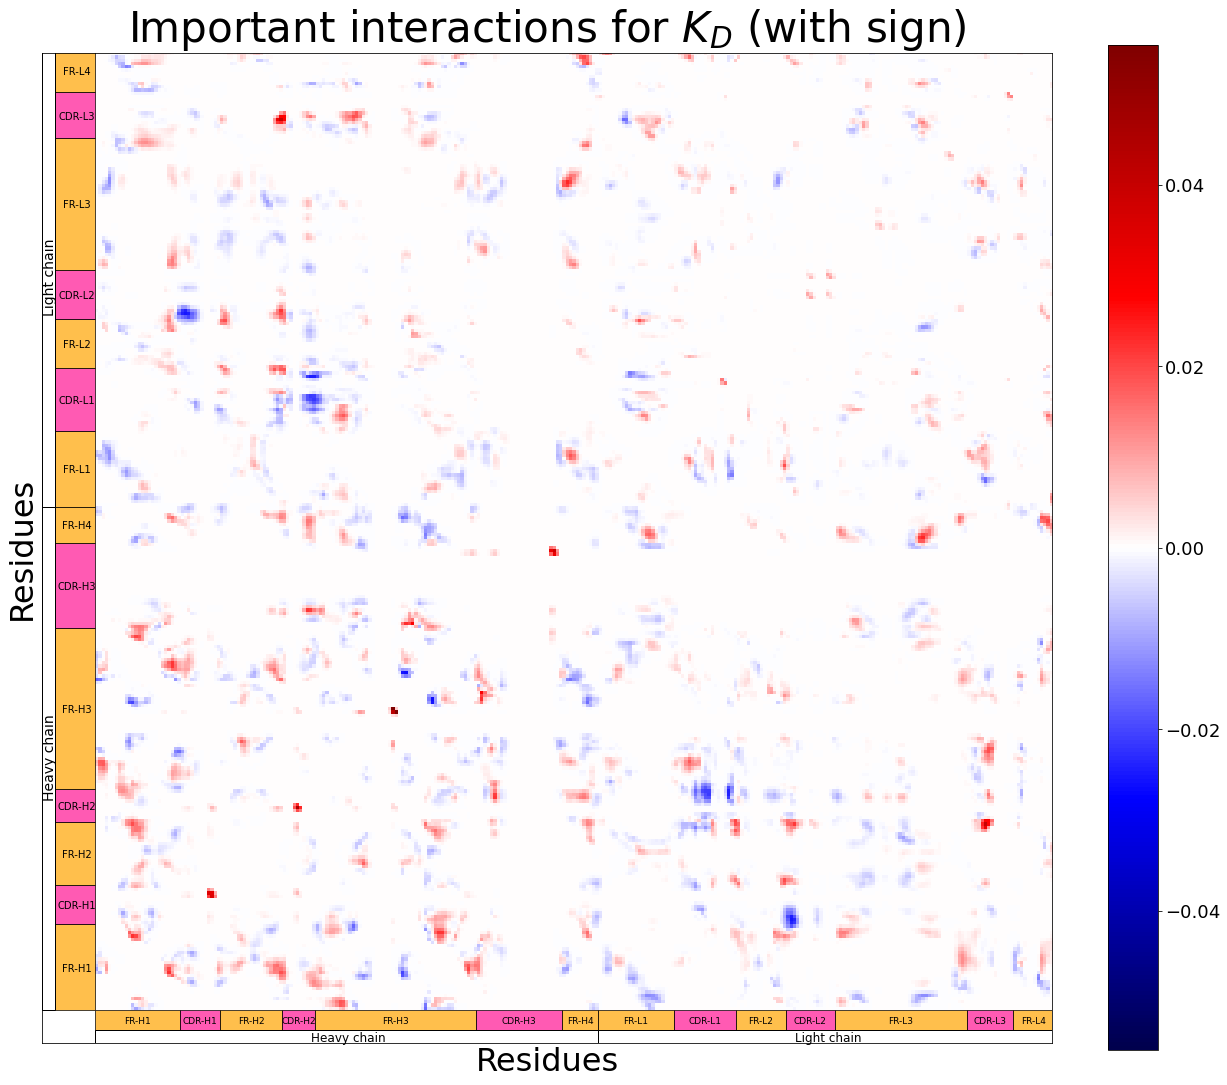

In [7]:
contribution_sample = get_test_contribution(preprocessed_data, model)
plot_map_with_regions(preprocessed_data, contribution_sample, 'Important interactions for $K_D$ (with sign)')

# UMAP

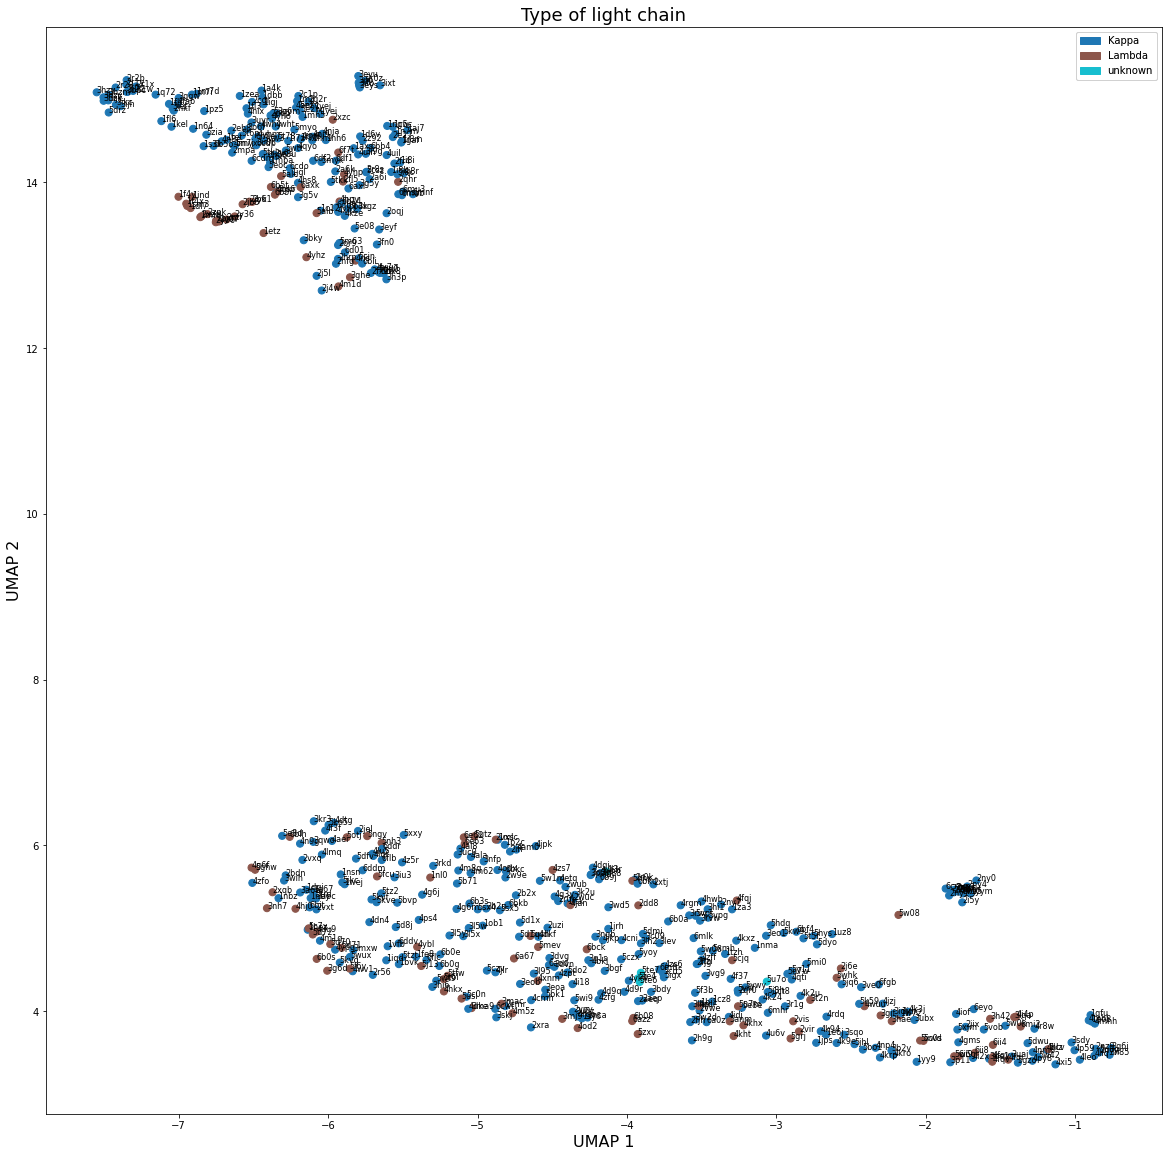

In [8]:
colours, pdb_files = compute_umap(preprocessed_data, model, scheme='light_ctype', categorical=True, include_ellipses=False, exclude_nanobodies=True)

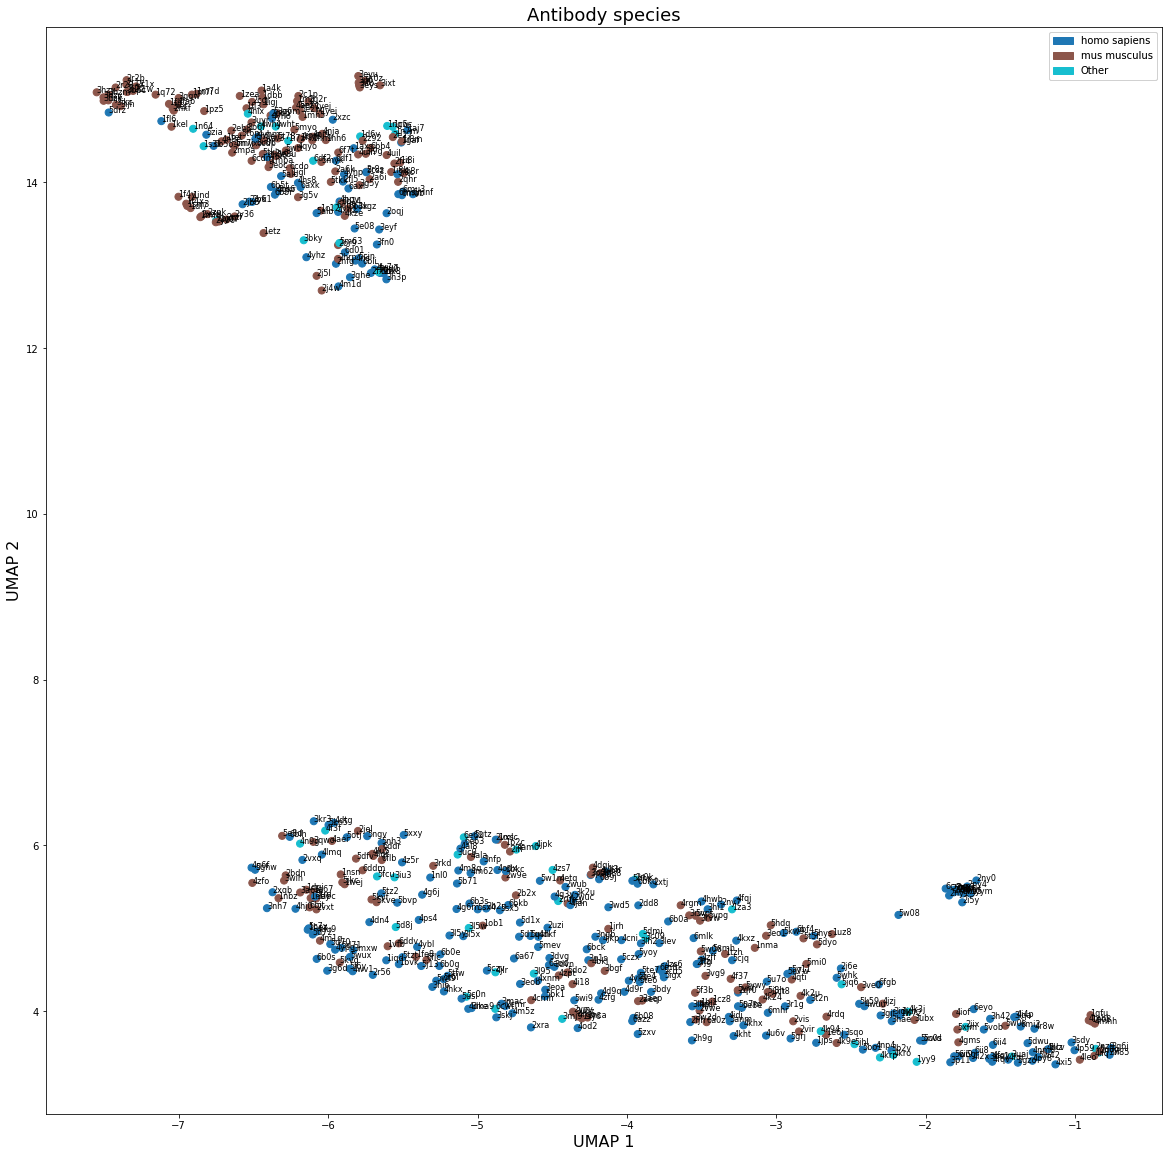

In [9]:
colours, pdb_files = compute_umap(preprocessed_data, model, scheme='heavy_species', categorical=True, include_ellipses=False, exclude_nanobodies=True)

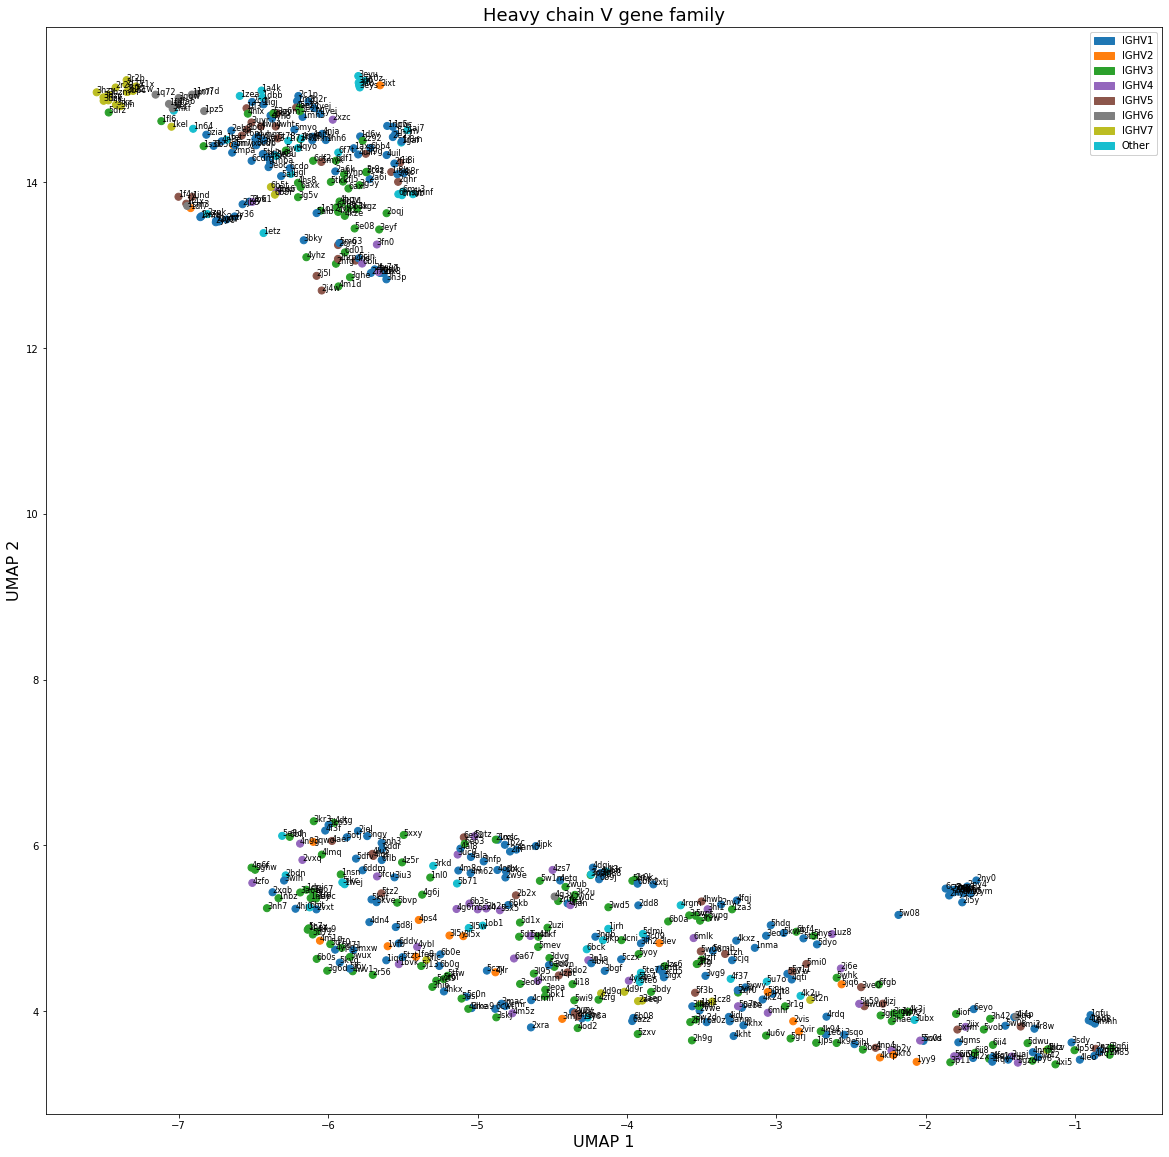

In [10]:
colours, pdb_files = compute_umap(preprocessed_data, model, scheme='heavy_subclass', categorical=True, include_ellipses=False, exclude_nanobodies=True)

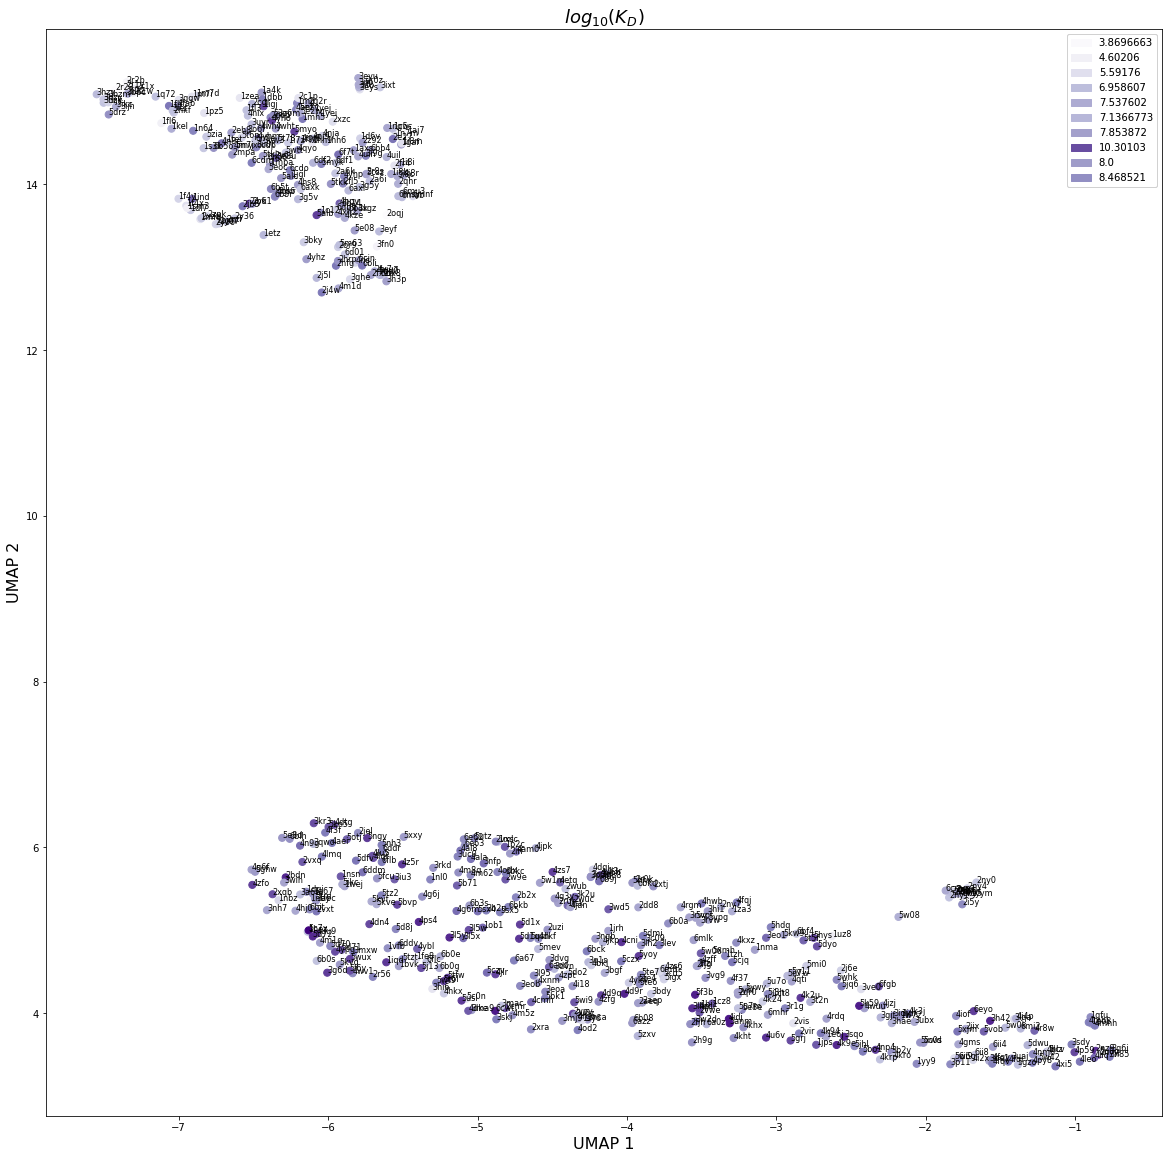

In [11]:
colours, pdb_files = compute_umap(preprocessed_data, model, scheme='$log_{10}(K_D)$', categorical=False, numerical_values=np.abs(preprocessed_data.train_y), exclude_nanobodies=True)

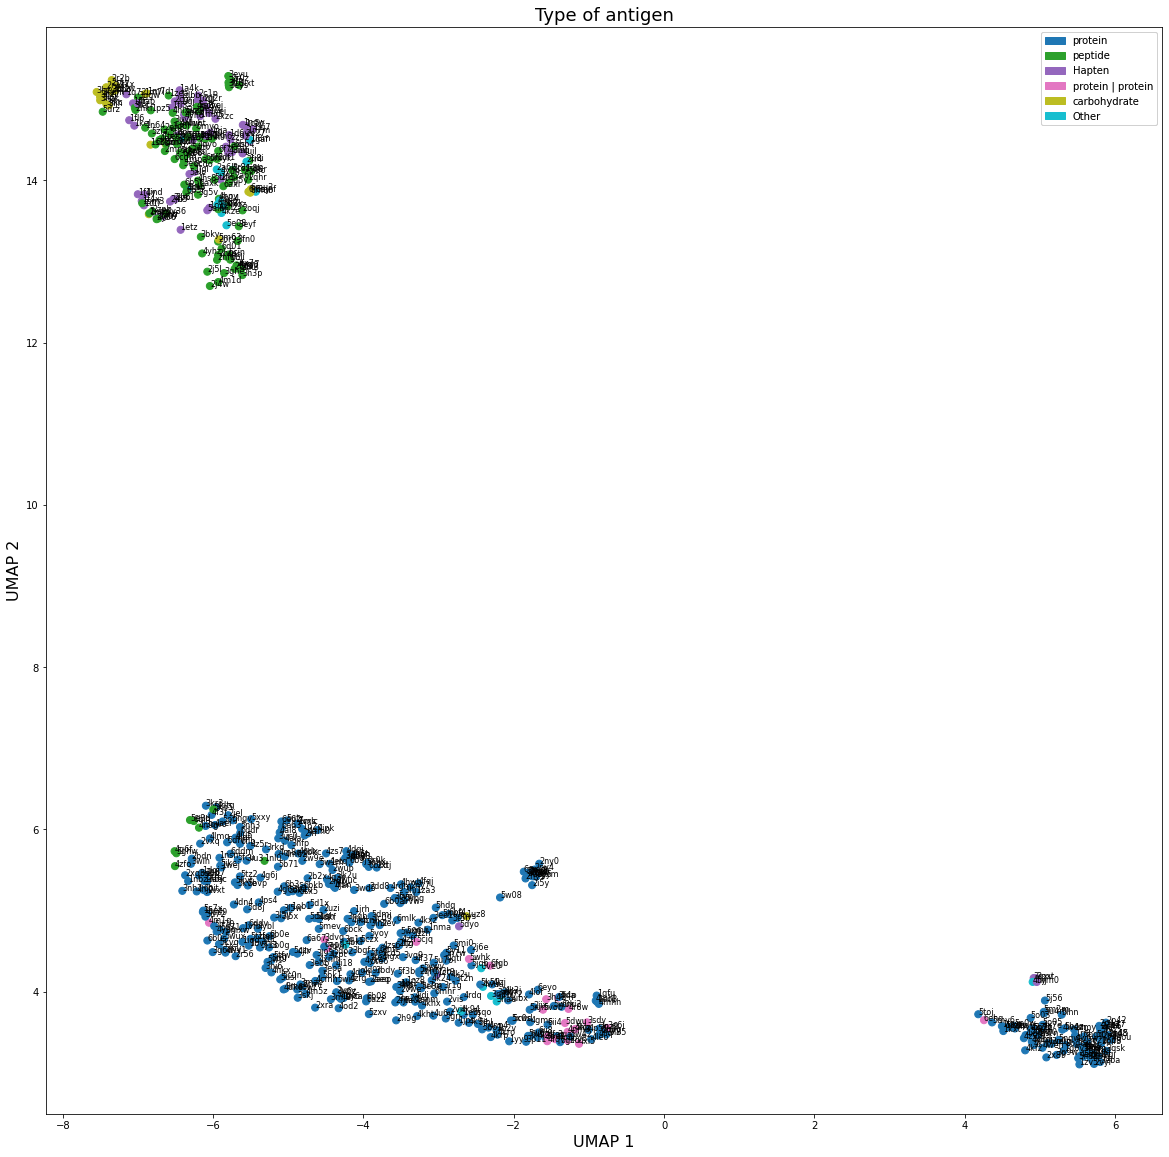

In [12]:
colours, pdb_files = compute_umap(preprocessed_data, model, scheme='antigen_type', categorical=True, include_ellipses=False, exclude_nanobodies=False)

## Region importance

### Inter-region vs intra-region

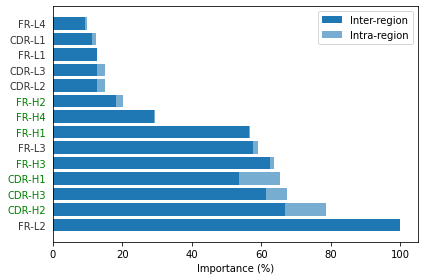

In [13]:
# Proteins/haptens/peptides/carbohydrates (type_of_antigen: 0/1/2/3)
type_of_antigen = 0
compute_region_importance(preprocessed_data, model, type_of_antigen, nanobodies, mode='region')

### Inter-chain vs intra-chain

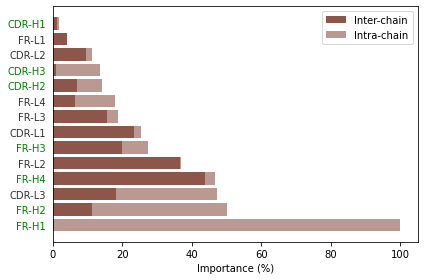

In [14]:
# Proteins/haptens/peptides/carbohydrates (type_of_antigen: 0/1/2/3)
type_of_antigen = 3
compute_region_importance(preprocessed_data, model, type_of_antigen, nanobodies, mode='chain')

## Residue importance

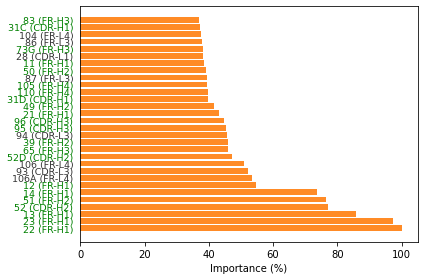

In [15]:
# Proteins/haptens/peptides/carbohydrates (type_of_antigen: 0/1/2/3)
type_of_antigen = 2
compute_residue_importance(preprocessed_data, model, type_of_antigen, nanobodies)

## Distance between Top 10 affinity-relevant correlations

In [16]:
# To generate distance matrices again, make sure to set: renew_maps=True, cmaps=True and cmaps_thr='all'
distance_matrices_gaps = Preprocessing(dccm_map_path='distance_matrices/', modes=modes, pathological=pathological, renew_maps=False, renew_residues=True, mode=mode)
each_img_enl = get_output_representations(preprocessed_data, model)
top_10_dist = []

for i in range(preprocessed_data.train_x.shape[0]):
    symmetric_matrix = np.tril(each_img_enl[i].reshape(input_shape, input_shape), k=-2)
    indices_of_top_values = np.unravel_index(np.argsort(np.abs(symmetric_matrix), axis=None)[-10:], symmetric_matrix.shape)
    top_10_dist.extend(distance_matrices_gaps.train_x[i][indices_of_top_values[0], indices_of_top_values[1]].tolist())

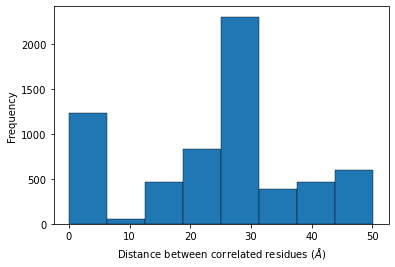

In [17]:
plt.hist(top_10_dist, bins=8, edgecolor='black', linewidth=.4)
plt.ylabel('Frequency')
plt.xlabel('Distance between correlated residues ($\AA$)')
plt.show()